In [47]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import pandas as pd
from typing import Iterable
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
def ingest_annotations(training, validation) -> Iterable[pd.DataFrame]:
  
  columns = ['category_id', 'bbox', 'area', 'iscrowd']
  return [pd.read_json(x, orient='records')[columns] for x in (training, validation)]

In [49]:
def load_image(row : pd.Series, dir : str):
#     return cv2.imread(os.path.join(dir, f"image_id_{row.name:03d}.jpg"))
    return os.path.join(dir, f"image_id_{row.name:03d}.jpg")

In [50]:
training_pd, validation_pd = ingest_annotations('train_annotations', 'valid_annotations')

In [51]:
training_pd['image']=training_pd.apply(load_image, axis=1, dir='training')
validation_pd['image']=validation_pd.apply(load_image, axis=1, dir='validation')

In [144]:
# tdata_dir = 'training'
# vdata_dir = 'images'

# data = tf.keras.utils.image_dataset_from_directory(tdata_dir)
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

datagen1 = ImageDataGenerator(validation_split=0.3) # change this according to your needs
train_generator=datagen1.flow_from_dataframe(
    dataframe=training_pd,
    directory=None,
    x_col="image",
    y_col="category_id",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="raw", # or 'binary' if you have only two classes
    target_size=(256,256)) # change this if you want a different image size
print(type(train_generator))
print(type(datagen1))

valid_generator=datagen1.flow_from_dataframe(
    dataframe=training_pd,
    directory=None,
    x_col="image",
    y_col="category_id",
    subset="validation",
    batch_size=32,
    shuffle=True,
    class_mode="raw", # or 'binary' if you have only two classes
    target_size=(256,256)) # change this if you want a different image size
print(type(valid_generator))


# datagen2 = ImageDataGenerator(rescale=1./255.) # change this according to your needs
# valid_generator=datagen2.flow_from_dataframe(
#     dataframe=validation_pd,
#     directory=None,
#     x_col="image",
#     y_col="category_id",
#     subset="validation",
#     batch_size=32,
#     seed=42,
#     shuffle=True,
#     class_mode="raw", # or 'binary' if you have only two classes
#     target_size=(32,32)) # change this if you want a different image size

Found 525 validated image filenames.
<class 'keras.preprocessing.image.DataFrameIterator'>
<class 'keras.preprocessing.image.ImageDataGenerator'>
Found 225 validated image filenames.
<class 'keras.preprocessing.image.DataFrameIterator'>


In [82]:
training_pd
validation_pd

,category_id,bbox,area,iscrowd,image
0,1,"[227, 93, 298, 525]",156450,0,validation\image_id_000.jpg
1,2,"[211, 198, 428, 259]",110852,0,validation\image_id_001.jpg
2,2,"[0, 243, 512, 267]",136704,0,validation\image_id_002.jpg
3,1,"[128, 178, 457, 354]",161778,0,validation\image_id_003.jpg
4,1,"[168, 131, 296, 469]",138824,0,validation\image_id_004.jpg
...,...,...,...,...,...
103,3,[],0,0,validation\image_id_103.jpg
104,3,[],0,0,validation\image_id_104.jpg
105,3,[],0,0,validation\image_id_105.jpg
106,3,[],0,0,validation\image_id_106.jpg


In [156]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 30, 30, 64)     

In [140]:
# model=tf.keras.applications.resnet50.ResNet50()
# model.compile('adam', loss=tf.losses.MeanSquaredError(), metrics=['accuracy'])

In [157]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[tensorboard_callback])

Epoch 1/10


c:\users\johnb\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 12s 667ms/step - loss: 0.0000e+00 - accuracy: 0.2610 - val_loss: 0.0000e+00 - val_accuracy: 0.5022
Epoch 2/10
17/17 [==============================] - 11s 649ms/step - loss: 0.0000e+00 - accuracy: 0.2610 - val_loss: 0.0000e+00 - val_accuracy: 0.5022
Epoch 3/10
17/17 [==============================] - 11s 644ms/step - loss: 0.0000e+00 - accuracy: 0.2610 - val_loss: 0.0000e+00 - val_accuracy: 0.5022
Epoch 4/10
17/17 [==============================] - 11s 647ms/step - loss: 0.0000e+00 - accuracy: 0.2610 - val_loss: 0.0000e+00 - val_accuracy: 0.5022
Epoch 5/10
10/17 [================>.............] - ETA: 4s - loss: 0.0000e+00 - accuracy: 0.2438

KeyboardInterrupt: 

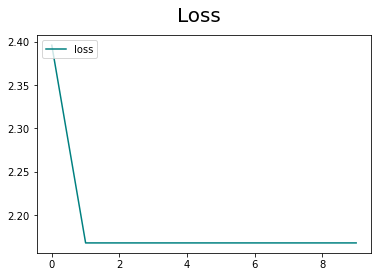

In [115]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

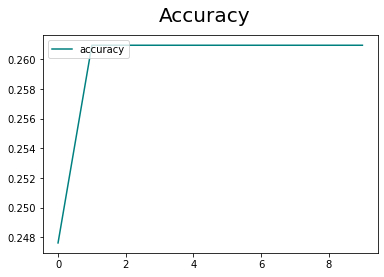

In [116]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [10]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


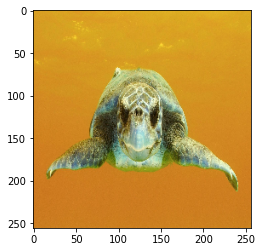

In [16]:
img = cv2.imread('testT.jpg')
# plt.imshow(img)
# plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [17]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5: 
    print(f'Predicted class is Turtle')
else:
    print(f'Predicted class is Penguin')

1/1 [==============================] - 0s 31ms/step
[[0.9790693]]
Predicted class is Turtle
